In [1]:
import glob
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
from utils import camera_calibration, combined_thresh, perspective_trans, fit_poly, fit_poly2, impose_lane
from line_finding import LineFinding

# Camera Calibration

In [3]:
mtx, dist = camera_calibration('./camera_cal/*.jpg', 9, 6)
images = glob.glob('./camera_cal/*.jpg')
for i in images:
    test_image = mpimg.imread(i)
    test_image_undistort = cv2.undistort(test_image, mtx, dist, None, mtx)
    plt.imsave("./output_images/camera_cal_undistort/"+i.split("/")[-1], test_image_undistort)   

# Color and Gradient Threshold

In [4]:
images = glob.glob("./test_images/test*.jpg")
for i in images:
    test_image = mpimg.imread(i)
    test_image_thre = combined_thresh(test_image)
    plt.imsave("./output_images/gradient_pic/thre_"+i.split("/")[-1], test_image_thre, cmap="gray")   

# Perspective Transform

In [5]:
src = np.float32([[577,463],[707,463],[244,688],[1059,688]])
dst = np.float32([[244,300],[1059,300], [244,700],[1059,700]])
M, Minv = perspective_trans(src, dst)

images = glob.glob("./test_images/test*.jpg")
for i in images:
    img = mpimg.imread(i)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(undist, M, (undist.shape[1], undist.shape[0]))
    plt.imsave("./output_images/perspective_trans/pers_"+i.split("/")[-1], warped)   

# Finding Lanes

In [6]:
images = glob.glob("./test_images/test*.jpg")
for i in images:
    img = mpimg.imread(i)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist_thre = combined_thresh(undist)
    warped = cv2.warpPerspective(undist_thre, M, (undist_thre.shape[1], undist_thre.shape[0]))
    left_fit, right_fit = fit_poly(warped, show=True)
    plt.savefig("./output_images/finding_lanes/lane_"+i.split("/")[-1])
    plt.close()

# Impose lane or original image

In [7]:
def impose_lane(warped, undist, left_fit, right_fit, Minv):
    # sample points
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #return result
    return result

In [8]:
images = glob.glob("./test_images/test*.jpg")
for i in images:
    img = mpimg.imread(i)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist_thre = combined_thresh(undist)
    warped = cv2.warpPerspective(undist_thre, M, (undist_thre.shape[1], undist_thre.shape[0]))
    left_fit, right_fit = fit_poly(warped)
    rst = impose_lane(warped, undist, left_fit, right_fit, Minv)
    plt.imsave("./output_images/imposing_lanes/final_"+i.split("/")[-1], rst)   

# Pipe Line

In [9]:
cali_img_dir='./camera_cal/*.jpg'
nx=9
ny=6
src = np.float32([[577,463],[707,463],[244,688],[1059,688]])
dst = np.float32([[244,300],[1059,300], [244,700],[1059,700]])

q = LineFinding()
q.preprocess(cali_img_dir, nx, ny, src, dst)

In [10]:
images = glob.glob("./test_images/test*.jpg")
for i in images:
    img = mpimg.imread(i)
    rst = q.pipeline(img)
    plt.imsave("./output_images/pipe_line/pipe_"+i.split("/")[-1], rst)   

# One Picture Example

In [11]:
img = mpimg.imread("./test_images/test1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
undist_thre = combined_thresh(undist)
warped = cv2.warpPerspective(undist_thre, M, (undist_thre.shape[1], undist_thre.shape[0]))
left_fit, right_fit = fit_poly(warped)
rst = impose_lane(warped, undist, left_fit, right_fit, Minv)

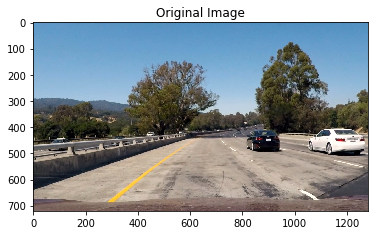

In [12]:
plt.imshow(img)
plt.title("Original Image")

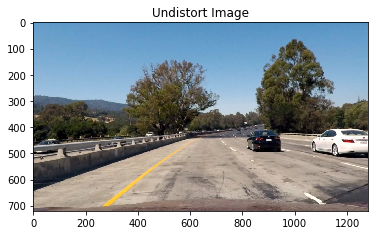

In [13]:
plt.imshow(undist)
plt.title("Undistort Image")

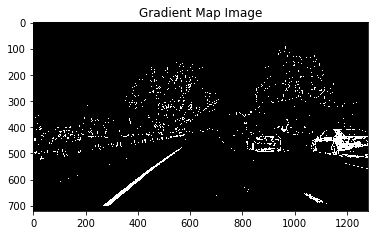

In [14]:
plt.imshow(undist_thre, cmap='gray')
plt.title("Gradient Map Image")

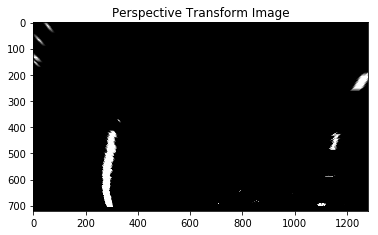

In [15]:
plt.imshow(warped, cmap='gray')
plt.title("Perspective Transform Image")

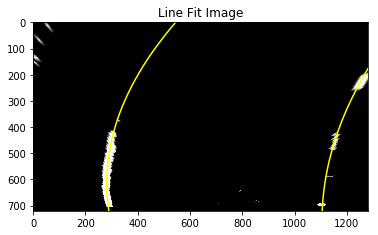

In [16]:
left_fit, right_fit = fit_poly(warped, show=True)
plt.title("Line Fit Image")

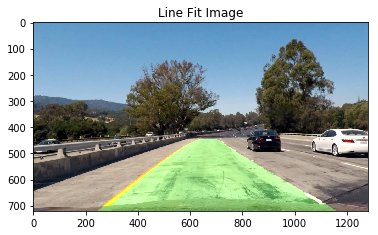

In [17]:
plt.imshow(rst)
plt.title("Line Fit Image")

# Make Video

In [18]:
from moviepy.editor import VideoFileClip

output = 'project_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
clip = clip1.fl_image(lambda img: q.pipeline(img, frame=True))
clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [04:57<00:00,  4.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

